# Auto Testbench
* use 200 images that are only for testing purpose
* automatic testing and result output

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import sys
sys.path.append('E:\\Leader LV5600\\LV5600 Automation\\')
from Constants import Constants as WAC

In [8]:
# Load test files
import os

# path to test files
test_dir = WAC.TEST_DATASET_PATH
test_categories = WAC.TEST_CATEGORIES

# check the 3 directories
for category in test_categories:
    path = os.path.join(test_dir, category)
    # check if the path exists
    if os.path.exists(path):
        print("Path exists: " + path)
        # print the number of files in each directory
        print(category + " has " + str(len(os.listdir(path))) + " files.")
    else:
        print("Path does not exist: " + path)
    

Path exists: E:\Data\TestSet\OverSaturated
OverSaturated has 70 files.
Path exists: E:\Data\TestSet\UnderSaturated
UnderSaturated has 80 files.
Path exists: E:\Data\TestSet\JustSaturated
JustSaturated has 50 files.


## Testing CNN model
* load model
* load test data
* predict
* output result


In [1]:
def test_CNN(model_name,test_mode, printInfo = True, convert_to_rgb=True):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import os
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import load_model
    from tensorflow.keras.preprocessing import image

    # model directory
    model_dir = WAC.MODEL_PATH
    model_under_test = model_name

    # preprocessing buffer directory
    preprocessing_buffer_dir = WAC.CNN_PREPROCESSING_BUFFER_PATH
    if not os.path.exists(preprocessing_buffer_dir):
        os.makedirs(preprocessing_buffer_dir)

    # define image size and ROI coordinates
    img_width, img_height = 240,670
    x_start,x_end,y_start,y_end = 600,1270,60,300

    # load the model
    model = load_model(os.path.join(model_dir, model_under_test))


    if test_mode == "single":
        user_input_category = input("Enter category: ")
        user_input_file_name = input("Enter file name: ")
        path = os.path.join(preprocessing_buffer_dir, user_input_category)
        img_under_test = os.path.join(path, user_input_file_name)
        img = image.load_img(img_under_test, target_size=(img_width, img_height))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img/255

        prediction = model.predict(img)
        if printInfo:
            print(img_under_test)
        class_ = np.argmax(prediction, axis=1)
        if class_ == 0:
            class_ = "Just Saturated"
        elif class_ == 1:
            class_ = "Over Saturated"
        elif class_ == 2:
            class_ = "Under Saturated"
        if printInfo:
            print("Prediction: ", class_)
            plt.imshow(img[0])
            plt.show()
    
    elif test_mode == "multi":
        # create dictionary to record prediction success and failure
        failure_dict = {}
        success_dict = {}

        for cat in test_categories:
            img_files = os.listdir(os.path.join(test_dir, cat))
            os.makedirs(os.path.join(preprocessing_buffer_dir, cat), exist_ok=True)
            for fname in img_files:
                img_path = os.path.join(test_dir, cat, fname)
                img = cv2.imread(img_path)
                if convert_to_rgb:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_roi = img[y_start:y_end, x_start:x_end]
                buffer_path = os.path.join(preprocessing_buffer_dir, cat, fname)
                cv2.imwrite(buffer_path, img_roi)

        # use model to classify images
        for cat in test_categories:
            for i,file in enumerate(os.listdir(os.path.join(preprocessing_buffer_dir, cat))):
                img = image.load_img(os.path.join(preprocessing_buffer_dir, cat, file), target_size=(img_width, img_height))
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = img/255

                prediction = model.predict(img)
                if printInfo:
                    print(file)
                class_ = np.argmax(prediction, axis=1)
                if class_ == 0:
                    class_ = "Just Saturated"
                elif class_ == 1:
                    class_ = "Over Saturated"
                elif class_ == 2:
                    class_ = "Under Saturated"  

                if cat == "OverSaturated" and class_ == "Over Saturated":
                    status = "success"
                elif cat == "UnderSaturated" and class_ == "Under Saturated":
                    status = "success"
                elif cat == "JustSaturated" and class_ == "Just Saturated":
                    status = "success"
                else:
                    status = "failure"

                if status == "success":
                    success_dict[file] = class_
                else:
                    failure_dict[file] = class_

                if printInfo:
                    print("File: ", file, "Prediction: ", class_, "Status: ", status)

                    #plt.imshow(img[0])
                    #plt.show()      
        if printInfo:
            print("Success: ", success_dict)
            print("Failure: ", failure_dict)    
            print("Success rate: ", len(success_dict)/(len(success_dict)+len(failure_dict)))
        return success_dict, failure_dict

In [10]:
# Driver code 
success_dict, failure_dict = test_CNN("model_20_20230615-134651.h5","multi", False,False)

# Evaluate the success and failure dictionaries
print("Success: ", success_dict)
print("Failure: ", failure_dict)
print("Success rate: ", len(success_dict)/(len(success_dict)+len(failure_dict)))

# Copy the failure files to a new directory
failure_dir = WAC.FAILED_TESTCASES_PATH
for cat in test_categories:
    os.makedirs(os.path.join(failure_dir, cat), exist_ok=True)
    for file in failure_dict.keys():
        # only copy if exist
        if os.path.exists(os.path.join(test_dir, cat, file)):
            shutil.copy(os.path.join(test_dir, cat, file), os.path.join(failure_dir, cat, file))



1/1 [==============================] - 0s 49ms/step
Success:  {'OverSaturatedClose0.bmp': 'Over Saturated', 'OverSaturatedClose1.bmp': 'Over Saturated', 'OverSaturatedClose2.bmp': 'Over Saturated', 'OverSaturatedClose3.bmp': 'Over Saturated', 'OverSaturatedClose4.bmp': 'Over Saturated', 'OverSaturatedClose5.bmp': 'Over Saturated', 'OverSaturatedClose6.bmp': 'Over Saturated', 'OverSaturatedClose7.bmp': 'Over Saturated', 'OverSaturatedClose8.bmp': 'Over Saturated', 'OverSaturatedClose9.bmp': 'Over Saturated', 'OverSaturatedExClose0.bmp': 'Over Saturated', 'OverSaturatedExClose1.bmp': 'Over Saturated', 'OverSaturatedExClose2.bmp': 'Over Saturated', 'OverSaturatedExClose3.bmp': 'Over Saturated', 'OverSaturatedExClose4.bmp': 'Over Saturated', 'OverSaturatedExClose5.bmp': 'Over Saturated', 'OverSaturatedExClose6.bmp': 'Over Saturated', 'OverSaturatedExClose7.bmp': 'Over Saturated', 'OverSaturatedExClose8.bmp': 'Over Saturated', 'OverSaturatedExClose9.bmp': 'Over Saturated', 'OverSaturatedMid

### Test Linear Regression Model

In [11]:
def linear_regression_process(img,plot_on = False,pixel_range = 50):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    import os

    # convert to normal RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # isolate the blue color pixels
    lower_blue = np.array([0,0,200])
    upper_blue = np.array([100,100,255])

    mask = cv2.inRange(img, lower_blue, upper_blue)
    img = cv2.bitwise_and(img, img, mask=mask)

    # find the coordinate pairs of the blue pixels
    y,x = np.where(mask==255)
    y = max(y) - y

   
    # locate the peak of the blue pixels, 
    peak = np.argmax(y)
    peak_x = x[peak]
    peak_y = y[peak]

    # arrange the coordinates in ascending order of x
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    xy = np.concatenate((x,y), axis=1)
    xy = xy[xy[:,0].argsort()]

    # find the coordinates to the left of the peak, compare x value, select 100 of them
    left_xy = xy[xy[:,0] < peak_x]
    left_xy = left_xy[-pixel_range:,:]

    # find the coordinates to the right of the peak, compare x value, select 100 of them
    right_xy = xy[xy[:,0] > peak_x]
    right_xy = right_xy[:pixel_range,:]


    # fit a linear regression model on the highlighted coordinates
    left_model = LinearRegression().fit(left_xy[:,0].reshape(-1,1), left_xy[:,1].reshape(-1,1))
    right_model = LinearRegression().fit(right_xy[:,0].reshape(-1,1), right_xy[:,1].reshape(-1,1))

    # Assuming the two straight lines are represented in the form of y = mx + c, where m is the slope of the line, you can calculate the angle between two lines using the formula:
    # tan(theta) = abs((m2 - m1) / (1 + m1*m2))

    # calculate the angle between the two lines
    angle = np.arctan(abs((right_model.coef_ - left_model.coef_) / (1 + left_model.coef_*right_model.coef_)))
    # the angle is in radians, convert to degrees
    angle = 180 -  angle * 180 / np.pi


    if plot_on:
        # plot the linear regression lines together with the original image
        plt.scatter(x,y)
        plt.plot(left_xy[:,0], left_model.predict(left_xy[:,0].reshape(-1,1)), color='red')
        plt.plot(right_xy[:,0], right_model.predict(right_xy[:,0].reshape(-1,1)), color='purple')
        plt.show()
        #convert angle to a value type, instead of an array
        angle = angle[0][0]
        print(angle)
    return angle

In [12]:

def test_linear_regression(mode, printInfo = False,pixel_range = 50):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    import os
    import random

    failure_dict = {}
    success_dict = {}

    oversaturate_angle = []
    undersaturate_angle = []
    justsaturate_angle = []

    # process image
    for cat in test_categories:
        img_files = os.listdir(os.path.join(test_dir, cat))
        for file in img_files:
            img = cv2.imread(os.path.join(test_dir, cat, file))
            angle = linear_regression_process(img, printInfo,pixel_range)
            if cat == "OverSaturated":
                oversaturate_angle.append(angle)
            elif cat == "UnderSaturated":
                undersaturate_angle.append(angle)
            elif cat == "JustSaturated":
                justsaturate_angle.append(angle)
    
    return oversaturate_angle, undersaturate_angle, justsaturate_angle
            



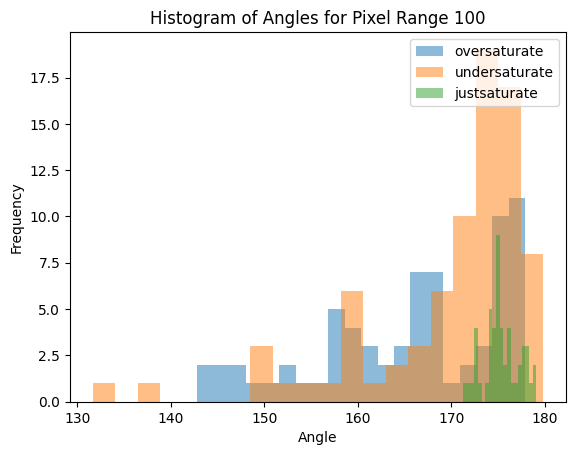

In [13]:
# Driver code 
'''
success_dict, failure_dict = test_linear_regression("multi", True)

# Evaluate the success and failure dictionaries
print("Success: ", success_dict)
print("Failure: ", failure_dict)
print("Success rate: ", len(success_dict)/(len(success_dict)+len(failure_dict)))
'''
test_pixel_range = [100]

import matplotlib.pyplot as plt
import numpy as np

# loop over test pixel range
for pixel_range in test_pixel_range:
    # run linear regression test
    oversaturate_angle, undersaturate_angle, justsaturate_angle = test_linear_regression("multi", False, pixel_range)

    # plot the histogram
    plt.hist(np.ravel(oversaturate_angle), bins=20, alpha=0.5, label='oversaturate')
    plt.hist(np.ravel(undersaturate_angle), bins=20, alpha=0.5, label='undersaturate')
    plt.hist(np.ravel(justsaturate_angle), bins=20, alpha=0.5, label='justsaturate')
    plt.legend(loc='upper right')
    #label the axes
    plt.xlabel('Angle')
    plt.ylabel('Frequency')
    #title the graph with pixel range
    plt.title(f"Histogram of Angles for Pixel Range {pixel_range}")
    plt.show()
